In [1]:
# import the library
%matplotlib inline

import ast
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler

import bokeh
import bokeh.plotting as plotting
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.tile_providers import CARTODBPOSITRON
plotting.output_notebook()

sns.set_style('whitegrid')

Loading BokehJS ...

# Problem definition

Cluster actors based on number of movies played, movie budget and populaity 

# Load the data

In [2]:
df = pd.read_csv('data/movies_new.csv')
df.head()

,id,title,budget,revenue,production_countries,release_date,popularity,vote_average,vote_count,genres,production_companies,belongs_to_collection,cast,keywords
0,36523,Felix The Cat: The Movie,9000000,1964253.0,"[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",1988-10-01,0.030576,3.7,5.0,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...","[{'name': 'Pannónia Filmstúdió', 'id': 48669},...",0,"[{'cast_id': 1, 'character': 'Felix the Cat (V...","[{'id': 9820, 'name': 'alternate dimension'}, ..."
1,68351,Sankofa,1000000,2691899.0,"[{'iso_3166_1': 'BF', 'name': 'Burkina Faso'},...",1993-05-28,0.045860,6.9,5.0,"[{'id': 18, 'name': 'Drama'}]","[{'name': 'Channel Four Films', 'id': 181}, {'...",0,"[{'cast_id': 6, 'character': 'Sankofa', 'credi...","[{'id': 409, 'name': 'africa'}, {'id': 2831, '..."
2,285908,The Last Breath,3800000,559298.0,"[{'iso_3166_1': 'CA', 'name': 'Canada'}]",1999-03-25,0.072704,4.0,2.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...","[{'name': 'Lions Gate Films', 'id': 35}]",0,"[{'cast_id': 0, 'character': 'Lauren Vaillanco...","[{'id': 10714, 'name': 'serial killer'}]"
3,121173,Voracious,11178,34659.0,"[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2012-09-05,0.079287,8.0,1.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'name': 'APT Entertainment', 'id': 8355}, {'...",0,"[{'cast_id': 16, 'character': 'Rene', 'credit_...","[{'id': 4694, 'name': 'staged death'}, {'id': ..."
4,110669,Wabash Avenue,2115000,2039000.0,"[{'iso_3166_1': 'US', 'name': 'United States o...",1950-03-31,0.109913,7.0,1.0,"[{'id': 10402, 'name': 'Music'}]",[{'name': 'Twentieth Century Fox Film Corporat...,0,"[{'cast_id': 1004, 'character': 'Ruby Summers'...","[{'id': 4344, 'name': 'musical'}, {'id': 4497,..."


In [3]:
# #input
# df = pd.read_csv('data/interventionscitoyendo.csv', encoding='latin_1')
# df['DATE'] = pd.to_datetime(df['DATE'])
# print(df.columns)
# print(df['CATEGORIE'].value_counts())
# df.head()


#df = pd.read_csv('data/movies.csv')
df['release_date'] = pd.to_datetime(df['release_date'])
df['year'] = df['release_date'].dt.year
print(df.dtypes)

#Setting cast, production_companies, genres and keywords types to a list of dictionaries

df['cast'] = df['cast'].astype(str)
df['production_countries'] = df['production_countries'].astype(str)
# df['genres'] = df['genres'].astype(str)
# df['production_companies'] = df['production_companies'].astype(str)

# df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x))
# df['production_companies'] = df['production_companies'].apply(lambda x: ast.literal_eval(x))
df['cast'] = df['cast'].apply(lambda x: ast.literal_eval(x))
df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x))

id                                int64
title                            object
budget                            int64
revenue                         float64
production_countries             object
release_date             datetime64[ns]
popularity                      float64
vote_average                    float64
vote_count                      float64
genres                           object
production_companies             object
belongs_to_collection            object
cast                             object
keywords                         object
year                              int64
dtype: object


Choosing columns

In [4]:
df = df[['title', 'budget', 'year', 'revenue', 'cast', 'production_countries', 'vote_average', 'vote_count']].copy()
print(df.head(5))

                      title   budget  year    revenue  \
0  Felix The Cat: The Movie  9000000  1988  1964253.0   
1                   Sankofa  1000000  1993  2691899.0   
2           The Last Breath  3800000  1999   559298.0   
3                 Voracious    11178  2012    34659.0   
4             Wabash Avenue  2115000  1950  2039000.0   

                                                cast  \
0  [{'cast_id': 1, 'character': 'Felix the Cat (V...   
1  [{'cast_id': 6, 'character': 'Sankofa', 'credi...   
2  [{'cast_id': 0, 'character': 'Lauren Vaillanco...   
3  [{'cast_id': 16, 'character': 'Rene', 'credit_...   
4  [{'cast_id': 1004, 'character': 'Ruby Summers'...   

                                production_countries  vote_average  vote_count  
0  [{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...           3.7         5.0  
1  [{'iso_3166_1': 'BF', 'name': 'Burkina Faso'},...           6.9         5.0  
2           [{'iso_3166_1': 'CA', 'name': 'Canada'}]           4.0         2.

# Feature Engineering 

Select a period

In [5]:
df = df[(df['year']>=2000)]
del df['year']
print(df.shape)

(3112, 7)


Keeping only movies which were produced in USA as the budget might be marked in US although in reality its not

In [6]:
df.reset_index(drop=True, inplace=True)
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value in item['name']]
list_creator = lambda df, idx: [1 if i in idx else 0 for i in df.index]

#Extracting list of countries
l=[]
for i, item in enumerate(df['production_countries']):
    for cell in item:
        l.append(cell['name'])
p_name, p_count = np.unique(np.array(l), return_counts=True)

prod = zip(p_name, p_count) # list of Unique Values along with occurrence Count
prod = list(prod)
prod = sorted(prod, key = lambda x: x[1], reverse = True)
print('Number of production countries: ', len(prod))

df = df.iloc[index_extractor(df, 'production_countries', 'United States of America'),:]
del df['production_countries']
print(df.shape)

Number of production countries:  68
(2522, 6)


In [7]:
df.head(5)

,title,budget,revenue,cast,vote_average,vote_count
10,Cruel World,2000000,16344.0,"[{'cast_id': 1, 'character': 'Philip Markham',...",4.8,6.0
19,Behind the Burly Q,250000,23859.0,"[{'cast_id': 2, 'character': '. Himself (arc...",5.5,3.0
20,The Internship,58000000,44000000.0,"[{'cast_id': 7, 'character': 'Nick Campbell', ...",6.1,1691.0
21,Resident Evil: Afterlife,60000000,300228084.0,"[{'cast_id': 11, 'character': 'Alice', 'credit...",5.8,1382.0
22,Eye of the Dolphin,2500000,71904.0,"[{'cast_id': 1, 'character': 'Alyssa', 'credit...",7.1,7.0


Extract Actors

In [8]:
df.reset_index(drop=True, inplace=True)
#Extracting list of actors
l = []

for i, item in enumerate(df['cast']):
    for cell in item:
        l.append(cell['name'])
       
    a_name, a_count = np.unique(np.array(l), return_counts=True)

idx=[]
for i, item  in enumerate(a_name):
    if (item == 'Kar') | (item == 'George') | (a_name[i] == 'Mario') | (a_name[i] == 'Jack') | (a_name[i] == 'Charle') | (a_name[i] == 'Charlie') | (a_name[i] == 'Mars') | (a_name[i] == 'Terry') | (a_name[i] == 'King') | (a_name[i] == 'Sim') | (a_name[i] == 'Elli') | (a_name[i] == 'Carlos') | (a_name[i] == 'Sandra') | (a_name[i] == 'Justin') | (a_name[i] == 'Shane') | (a_name[i] == 'Angela') | (a_name[i] == 'Eve') | (a_name[i] == 'Foster') | (a_name[i] == 'Take') | (a_name[i] == 'Andrea') | (a_name[i] == 'Ade') | (a_name[i] == 'Tiffany') | (a_name[i] == 'Zoë'):
        idx.append(i)


# for item in zip(a_name, a_count):
#     if item[0] == "Cher'":
#         print(item[0], item[1])

    
a_name = np.delete(a_name, idx)
a_count = np.delete(a_count, idx)
df.reset_index(drop=True, inplace=True)
print('number of actors: ', len(a_name))

# Creating lists of features for each actor
print('Creating lists of features for each actor')
index_extractor = lambda df, field, value: [idx for idx, entries in enumerate(df[field]) for item in entries if value == item['name']]
list_rev_creator =  lambda df, idx: [df.loc[i,'revenue'] if i in idx else 0 for i in df.index] # List of revenues for current actor
list_pop_creator =  lambda df, idx: [df.loc[i,'vote_count'] if i in idx else 0 for i in df.index] # List of popularities for current actor
list_vote_creator =  lambda df, idx: [df.loc[i,'vote_average'] if i in idx else 0 for i in df.index]
list_bud_creator =  lambda df, idx: [df.loc[i,'budget'] if i in idx else 0 for i in df.index]

a_rev = []
a_pop = []
a_rev_sum = []
a_pop_sum = []
a_vote = []
a_vote_sum = []
a_bud = []
a_bud_sum = []

for actor, count in zip(a_name, a_count):
    idx = index_extractor(df, 'cast', actor)

    actor_rev = list_rev_creator(df, idx)   
    a_rev.append(np.sum(actor_rev)/count) 
    a_rev_sum.append(np.sum(actor_rev)) 

    actor_pop = list_pop_creator(df, idx)   
    a_pop.append(np.sum(actor_pop)/count)    
    a_pop_sum.append(np.sum(actor_pop))    

    actor_vote = list_vote_creator(df, idx)   
    a_vote.append(np.sum(actor_vote)/count)    
    a_vote_sum.append(np.sum(actor_vote))

    actor_bud = list_bud_creator(df, idx)   
    a_bud.append(np.sum(actor_bud)/count)    
    a_bud_sum.append(np.sum(actor_bud))

print('finished')

number of actors:  36856
Creating lists of features for each actor
finished


Refactor our Dataframe to be presented by its actors

In [9]:
print(type(a_name), type(a_count), type(a_rev))

a_name_s = pd.Series(a_name)
a_count_s = pd.Series(a_count)
a_rev_s =  pd.Series(a_rev)
a_rev_sum_s = pd.Series(a_rev_sum)
a_pop_s = pd.Series(a_pop)

a_pop_sum_s = pd.Series(a_pop_sum)
a_vote_s = pd.Series(a_vote)
a_vote_sum_s = pd.Series(a_vote_sum)
a_bud_s = pd.Series(a_bud)
a_bud_sum_s = pd.Series(a_bud_sum)

df_act = a_name_s.to_frame()

df_act = df_act.assign(a_count_s=a_count_s.values)
df_act = df_act.assign(a_rev_s=a_rev_s.values)
df_act = df_act.assign(a_rev_sum_s=a_rev_sum_s.values)
df_act = df_act.assign(a_pop_s=a_pop_s.values)
df_act = df_act.assign(a_pop_sum_s=a_pop_sum_s.values)
df_act = df_act.assign(a_vote_s=a_vote_s.values)
df_act = df_act.assign(a_vote_sum_s=a_vote_sum_s.values)
df_act = df_act.assign(a_bud_s=a_bud_s.values)
df_act = df_act.assign(a_bud_sum_s=a_bud_sum_s.values)

df_act.rename(columns={0:'name'}, inplace=True)
df_act.rename(columns={'a_count_s':'num_movies'}, inplace=True)
df_act.rename(columns={'a_rev_s':'ave_revenue'}, inplace=True)
df_act.rename(columns={'a_rev_sum_s':'sum_revenue'}, inplace=True)
df_act.rename(columns={'a_bud_s':'ave_budget'}, inplace=True)
df_act.rename(columns={'a_bud_sum_s':'sum_budget'}, inplace=True)
df_act.rename(columns={'a_pop_s':'ave_count_vote'}, inplace=True)
df_act.rename(columns={'a_pop_sum_s':'sum_count_vote'}, inplace=True)
df_act.rename(columns={'a_vote_s':'ave_vote'}, inplace=True)
df_act.rename(columns={'a_vote_sum_s':'sum_ave_votes'}, inplace=True)

df_act.head(10)


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>


,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget
0,"""Weird Al"" Yankovic",1,3.942147e+07,3.942147e+07,273.000000,273.0,5.100000,5.1,1.500000e+07,15000000
1,'Sister' Carol East,1,4.132533e+07,4.132533e+07,273.000000,273.0,5.600000,5.6,1.800000e+07,18000000
2,50 Cent,11,9.472218e+07,1.041944e+09,841.545455,9257.0,6.054545,66.6,3.620182e+07,398220000
3,A. Cheron Hall,1,3.000000e+07,3.000000e+07,154.000000,154.0,5.600000,5.6,2.500000e+07,25000000
4,A. David Burleigh,1,1.237241e+07,1.237241e+07,51.000000,51.0,4.700000,4.7,2.400000e+07,24000000
5,A. Frank Ruffo,2,5.053966e+07,1.010793e+08,501.000000,1002.0,6.150000,12.3,2.900000e+07,58000000
6,A. J. Benza,1,1.557211e+08,1.557211e+08,858.000000,858.0,6.500000,6.5,2.400000e+07,24000000
7,A. Jay Radcliff,1,2.045940e+08,2.045940e+08,655.000000,655.0,5.800000,5.8,6.000000e+07,60000000
8,A. P. Singh,1,2.437715e+07,2.437715e+07,876.000000,876.0,7.100000,7.1,1.600000e+07,16000000
9,A. Russell Andrews,2,1.281675e+08,2.563351e+08,1083.500000,2167.0,6.900000,13.8,3.050000e+07,61000000


In [10]:
df_act[df_act['num_movies'] > 15].sort_values('ave_count_vote', ascending=False)

,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget
32655,Stan Lee,29,6.694081e+08,1.941283e+10,5840.206897,169366.0,6.696552,194.2,1.682069e+08,4878000000
13933,Ian McKellen,16,6.738589e+08,1.078174e+10,4754.187500,76067.0,6.987500,111.8,1.540625e+08,2465000000
2059,Andy Serkis,16,6.405405e+08,1.024865e+10,4420.687500,70731.0,6.975000,111.6,1.324375e+08,2119000000
17421,John Ratzenberger,16,6.315950e+08,1.010552e+10,4297.250000,68756.0,7.062500,113.0,1.553750e+08,2486000000
24552,Michael Caine,23,3.293200e+08,7.574359e+09,3799.260870,87383.0,6.726087,154.7,9.226522e+07,2122100000
643,Alan Rickman,17,5.678809e+08,9.653976e+09,3570.058824,60691.0,7.088235,120.5,1.075882e+08,1829000000
12211,Gary Oldman,20,4.588555e+08,9.177110e+09,3535.600000,70712.0,6.800000,136.0,1.115750e+08,2231500000
29695,Robert Downey Jr.,22,3.871379e+08,8.517035e+09,3524.000000,77528.0,6.709091,147.6,9.934091e+07,2185500000
6356,Chris Hemsworth,17,3.935367e+08,6.690123e+09,3472.235294,59028.0,6.405882,108.9,1.218235e+08,2071000000
27515,Paul Bettany,21,4.162083e+08,8.740375e+09,3250.000000,68250.0,6.557143,137.7,1.055000e+08,2215500000


### Coose columns

In [30]:
# ['num_movies', 'ave_revenue', 'sum_revenue', 'ave_count_vote', 'sum_count_vote', 'ave_vote', 'sum_ave_votes', 'ave_budget', 'sum_budget']

X_columns = ['num_movies', 'ave_revenue', 'ave_count_vote', 'ave_vote', 'ave_budget']
X = df_act[X_columns]
X.head()

,num_movies,ave_revenue,ave_count_vote,ave_vote,ave_budget
0,1,3.942147e+07,273.000000,5.100000,1.500000e+07
1,1,4.132533e+07,273.000000,5.600000,1.800000e+07
2,11,9.472218e+07,841.545455,6.054545,3.620182e+07
3,1,3.000000e+07,154.000000,5.600000,2.500000e+07
4,1,1.237241e+07,51.000000,4.700000,2.400000e+07


### Normalize

In [31]:
# normalize the data
for col in X_columns:
    X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1))

C:\Users\Anastasia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Anastasia\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [32]:
X.head()


,num_movies,ave_revenue,ave_count_vote,ave_vote,ave_budget
0,-0.360773,-0.591989,-0.732598,-1.614793,-0.814995
1,-0.360773,-0.584918,-0.732598,-0.962942,-0.759687
2,3.635213,-0.386609,-0.442470,-0.370349,-0.424121
3,-0.360773,-0.626979,-0.793323,-0.962942,-0.630636
4,-0.360773,-0.692446,-0.845884,-2.136274,-0.649072


In [33]:
X.shape

(36856, 5)

# Model Training

In [40]:
# model = DBSCAN(eps=0.5, min_samples=200)

k = 4
model = KMeans(n_clusters=k).fit(X[X_columns]) 
model.fit(X[X_columns])

cluster_labels = model.labels_
n_clusters = len(set(cluster_labels))

print(collections.Counter(cluster_labels))

X['cluster'] = cluster_labels


Counter({3: 15343, 0: 14894, 1: 5213, 2: 1406})


C:\Users\Anastasia\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [41]:
df_results = df_act.copy()
df_results['cluster'] = cluster_labels
df_results.sort_values('cluster', ascending=False)

,name,num_movies,ave_revenue,sum_revenue,ave_count_vote,sum_count_vote,ave_vote,sum_ave_votes,ave_budget,sum_budget,cluster
0,"""Weird Al"" Yankovic",1,39421467.0,39421467.0,273.000000,273.0,5.100000,5.1,15000000.0,15000000,3
19628,Kelsey Keel,1,17500000.0,17500000.0,163.000000,163.0,5.800000,5.8,10000000.0,10000000,3
19649,Ken Arnold,1,82087155.0,82087155.0,987.000000,987.0,5.600000,5.6,35000000.0,35000000,3
19648,Ken Anthony II,1,167221571.0,167221571.0,1062.000000,1062.0,6.100000,6.1,7000000.0,7000000,3
19645,Kemaal Deen-Ellis,1,240697856.0,240697856.0,2776.000000,2776.0,5.400000,5.4,125000000.0,125000000,3
19643,Kelvin Payton,2,17307353.5,34614707.0,116.000000,232.0,6.200000,12.4,20000000.0,40000000,3
19639,Kelvin Felix,1,67112664.0,67112664.0,306.000000,306.0,5.200000,5.2,70000000.0,70000000,3
19632,Kelsey O'Brien,1,105011053.0,105011053.0,593.000000,593.0,5.800000,5.8,30000000.0,30000000,3
19630,Kelsey Lansdowne,1,69834815.0,69834815.0,109.000000,109.0,6.100000,6.1,50000000.0,50000000,3
19629,Kelsey Lack,1,59418613.0,59418613.0,392.000000,392.0,6.000000,6.0,75000000.0,75000000,3


In [42]:
# Analyze the results
for cluster in set(cluster_labels):
    print((cluster), (len(df_results[df_results['cluster']==cluster]['name'])))
#     print(sorted(list(df_results[df_results['cluster']==cluster]['Country'])))

# Analyze the centroids
df_results.groupby('cluster').mean().round(2).T

0 14894
1 5213
2 1406
3 15343


cluster,0,1,2,3
num_movies,1.450000e+00,1.430000e+00,1.199000e+01,1.580000e+00
ave_revenue,1.283305e+08,7.107378e+08,1.893047e+08,9.418803e+07
sum_revenue,2.042171e+08,9.795598e+08,2.321859e+09,1.614698e+08
ave_count_vote,1.484130e+03,5.284290e+03,1.486950e+03,7.319900e+02
sum_count_vote,2.256460e+03,7.110240e+03,1.821594e+04,1.248650e+03
ave_vote,6.850000e+00,6.890000e+00,6.250000e+00,5.660000e+00
sum_ave_votes,9.840000e+00,9.820000e+00,7.508000e+01,9.020000e+00
ave_budget,3.923065e+07,1.588574e+08,6.004238e+07,4.466465e+07
sum_budget,6.255345e+07,2.195689e+08,7.351137e+08,7.176131e+07


[(1, 11147), (2, 2123), (3, 839), (4, 381), (5, 254)]
[(1, 3973), (2, 726), (3, 263), (4, 129), (5, 59)]
[(7, 244), (8, 219), (9, 187), (10, 126), (11, 92)]
[(1, 10784), (2, 2361), (3, 1059), (4, 506), (5, 344)]
num_movies


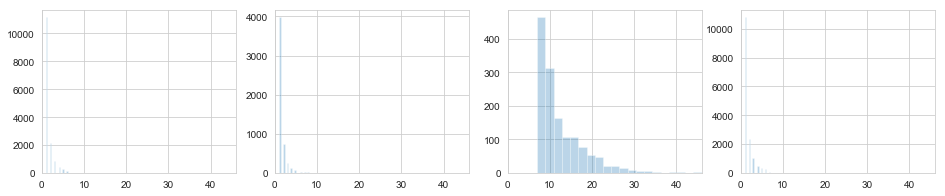

ave_revenue


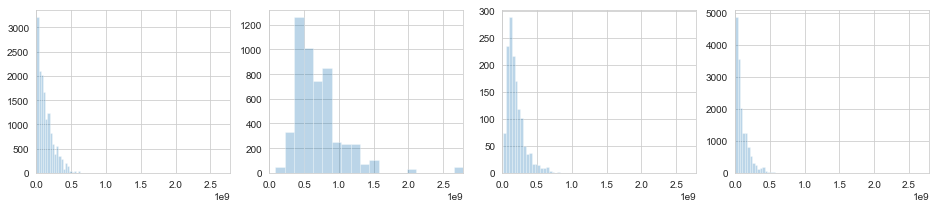

ave_count_vote


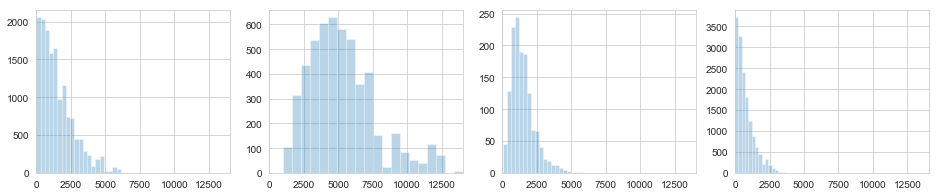

ave_vote


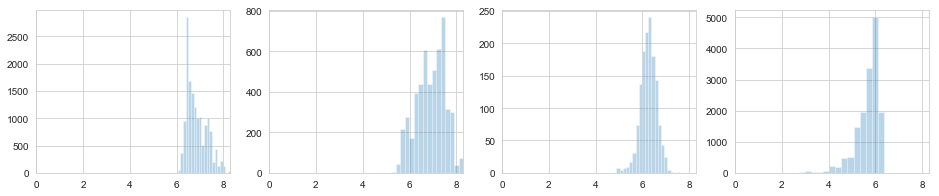

ave_budget


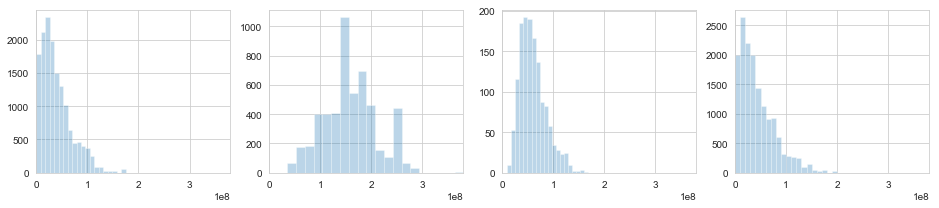

In [43]:
# Analyze the results
df_results = df_results.reset_index()
for cluster in sorted(set(model.labels_)):
    print(collections.Counter(df_results[df_results['cluster']==cluster]['num_movies']).most_common(5))

n_clusters = len(set(model.labels_))
for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(16,3))
    for cluster in sorted(set(model.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([0,df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], label=str(cluster), alpha=0.3, bins=20)
        i += 1
    plt.show()

# Model Evaluation

In [44]:
# Inter-Cluster
centroids = []
for cluster in sorted(set(model.labels_)):
    centroids.append(X[X['cluster']==cluster][X_columns].mean().values)
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])
print('Inter Cluster distance', np.mean(distances))

# Intra-Cluster
distances = []
for cluster in sorted(set(model.labels_)):
    df_filter = X[X['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])
print('Intra Cluster distance', np.mean(distances))

# Inertia
distances = []
for cluster in sorted(set(model.labels_)):
    df_filter = X[X['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values
    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
print('Inertia', np.sum(distances))

Inter Cluster distance 1.588852561675251
Intra Cluster distance 0.34604555116228347
Inertia 75025.39131150293


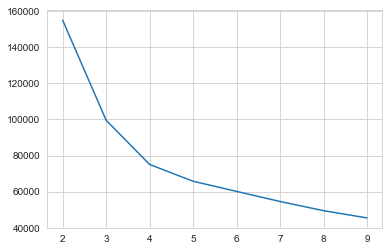

In [45]:
inertia = []
number_k = []
for k in range(2, 10, 1):
    kmeans = KMeans(n_clusters=k).fit(X.values)
    inertia.append(kmeans.inertia_)
    number_k.append(k)
plt.plot(number_k, inertia)
plt.show()

# Hierarchical Model Training 

In [ ]:
import scipy
import scipy.cluster.hierarchy as sch
import collections

In [ ]:
# X = df_act[X_columns]
# X.head()

In [ ]:
# # normalize the data
# for col in X_columns:
#     X[col] = StandardScaler().fit_transform(X[col].values.reshape(-1, 1))

In [ ]:
# k = 3
# color_threshold = 99.
# d = sch.distance.pdist(X[['num_movies', 'sum_count_vote']])
# Z= sch.linkage(d, method = 'ward') # minimize within cluster variation
# T = sch.fcluster(Z, k, 'maxclust')
# P = sch.dendrogram(Z, color_threshold=color_threshold)
# plt.show()

# print(set(T))
# print(collections.Counter(T))

# df_results = df_act.copy()
# df_results['cluster'] = T
# df_act['cluster'] = T

In [ ]:
# # Analyze the results
# for cluster in set(T):
#     print((cluster), (len(df_results[df_results['cluster']==cluster]['name'])))
#     print(sorted(list(df_results[df_results['cluster']==cluster]['name'])))

In [ ]:
# # Analyze the centroids
# df_results.groupby('cluster').mean().round(2).T

In [ ]:
# inertia = []
# number_k = []
# for k in range(2,15,1):
#     d = sch.distance.pdist(X[X_columns])
#     Z= sch.linkage(d, method = 'ward')
#     T = sch.fcluster(Z, k, 'maxclust')
#     df_act['cluster'] = T

#     # Inertia
#     distances = []
#     for cluster in sorted(set(T)):
#         df_filter = df_act[df_act['cluster']==cluster]
#         centroid = df_filter[X_columns].mean().values
#         for _, v in df_filter[X_columns].iterrows():
#             distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])
#     inertia.append(np.sum(distances))
#     number_k.append(k)
# plt.plot(number_k, inertia)
# plt.show()